# Recommender Systems
## Writing an Algorithm for Recommending Movies with a Collaborative Filtering
In dit script probeer ik een algoritme te schrijven die de beoordeling van films gaat voorspellen voor mensen. Recommender Systems worden gebruikt door bedrijven zoals YouTube en Netflix om jou langer op hun platform te houden. Ook kan het gebruikt worden door online kledingwinkels die willen voorspellen welke kleding jij leuk vindt.

De dataset die wordt gebruikt is de MovieLens database. Deze is te vinden op [grouplens.org/](https://grouplens.org/datasets/movielens/). Daarnaast gebruik ik de kennis die ik heb opgedaan vanuit dit [Towards Data Science](https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b) artikel.

Deze notebook is een gevolg op `CB_RecommenderSystem.ipynb` en mijn aanbeveling is om die eerst te snappen. Die geeft je in het simpel het idee van een recommender system. In tegenstelling tot CB probeert Collaborative Filtering te kijken naar de patronen van de gebruikers. 

In [1]:
import pandas as pd 
import numpy as np
import warnings
import matplotlib.pyplot as plt

from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy

%matplotlib inline
warnings.filterwarnings('ignore')

Het belangrijkste wat in de volgende cell gebeurd is het inlezen van de data en het samenvoegen van de twee datasets. De variable `BigDataSet` bepaald of je de grote data set pakt van 20 miljoen regels (`True`) of de kleine dataset van 100.000 regels (`False`).

## Data Preprocessing

Voor de surprise methode is er bijna geen data preprocessing nodig. Het enige wat nodig is is een tabel met userID's, movieID's en ratings.

| userID | movieID | Rating |
| --- | --- | --- |
| 1 | 1 | 5 |
| 1 | 2 | 3 |
| 2 | 1 | 4 |


In [2]:
BigDataSet = False
DataSet = "data" if BigDataSet else "data_small"

df = pd.read_csv(DataSet + '/ratings.csv', sep=',', names=['userID','movieID','rating','timestamp'], header = 0)
df.head()

,userID,movieID,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Scikit surprise approach
https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b

In [3]:
# Train Test split fit
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df[["userID", "movieID", "rating"]], reader)
trainSet, testSet = train_test_split(data, test_size = 0.2)

movieSVD = SVD(random_state = 1, verbose = True, n_epochs = 5)
movieSVD.fit(trainSet)

# test the algorithm
predictions = movieSVD.test(testSet)
accuracy.rmse(predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
RMSE: 0.8928


0.8928012191357797

In [4]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainSet.ur[trainSet.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainSet.ir[trainSet.to_inner_iid(iid)])
    except ValueError:
        return 0

In [8]:
dfPred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
dfPred = dfPred.drop('details', axis = 1)
dfPred["SE"] = (dfPred.est-dfPred.rui)**2
dfPred['Iu'] = dfPred.uid.apply(get_Iu)
dfPred['Ui'] = dfPred.iid.apply(get_Ui)
dfPred = dfPred.sort_values(by = "Ui", ascending = True)
dfPred.head(30)

,uid,iid,rui,est,SE,Iu,Ui
0,474,8921,3.5,3.367641,0.017519,1709,0
1616,140,4243,4.0,3.370065,0.396818,469,0
12133,599,43908,3.0,2.612287,0.150321,1984,0
12149,307,4181,2.0,2.719357,0.517475,768,0
1609,50,4399,3.5,2.692341,0.652313,247,0
12243,601,141846,4.0,4.027706,0.000768,77,0
12250,382,158254,1.5,3.530528,4.123044,229,0
12277,599,95717,2.0,2.612287,0.374896,1984,0
12279,111,130087,3.0,3.307488,0.094549,520,0
12283,441,4402,5.0,3.940663,1.122196,32,0


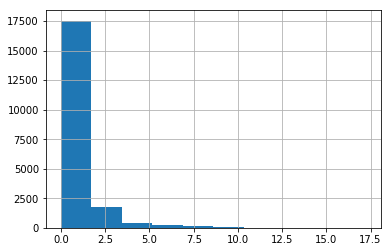

In [6]:
dfPred.SE.hist()